In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from IPython.display import clear_output
from torch.autograd import Variable
%matplotlib inline

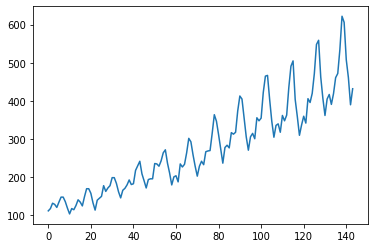

In [22]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [23]:
len(dataset)

144

In [24]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [25]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.68)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

97 47


In [26]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [27]:
look_back = 3
look_forward = 1
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

trainX = np.reshape(trainX, (trainX.shape[0], 1,  trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [28]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))

In [29]:
(train_dataset[0][0], train_dataset[0][1])

(tensor([[0.0154, 0.0270, 0.0541]]), tensor([0.0483]))

In [30]:
batch_size = 1
train_dataloader =  DataLoader(train_dataset, batch_size = batch_size)
epochs = 100
seq_len = look_back
input_size = 1
koll_test = len(test)


In [36]:
class LSTM_with_enter(nn.Module):
    def __init__(self, input_size = 1, num_layers = 1, hidden_size = 100, output_size = 1, batch_size = 1):
        super().__init__()
        self.hidden_size = hidden_size

        self.num_layers = num_layers
        
        self.batch_size = batch_size
        
        self.lstm = nn.LSTM(input_size,  hidden_size, num_layers)

        self.linear = nn.Linear(hidden_size * batch_size , output_size)

        self.hidden_cell = (torch.zeros(self.num_layers, self.batch_size, self.hidden_size),
                            torch.zeros(self.num_layers, self.batch_size, self.hidden_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) , self.batch_size, input_size), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [37]:
model = LSTM_with_enter()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [38]:
def evald(seq_len, koll_test, train_dataset, dataset):
    dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
    test_inputs = train_dataset[-1, 0][0].tolist()
    model.eval()
    for j in range(koll_test):
        seq = torch.FloatTensor(test_inputs[-seq_len:])
        with torch.no_grad():
            model.hidden = (torch.zeros(model.num_layers, batch_size, model.hidden_size),
                            torch.zeros(model.num_layers, batch_size, model.hidden_size))
            test_inputs.append(model(seq).item())
    
    actual_predictions = scaler.inverse_transform(np.array(test_inputs[seq_len:] ).reshape(-1, 1))
    x = np.arange(len(dataset) - koll_test - 1, len(dataset) - 1, 1)
    
    clear_output(True)
    plt.title('Month vs Passenger')
    plt.ylabel('Total Passengers')
    plt.grid(True)
    plt.autoscale(axis='x', tight=True)
    plt.plot(dataset)
    plt.plot(x,actual_predictions)
    plt.show()

In [39]:
def train(epochs, seq_len, input_size, train_dataloader):
    model.train()
    for i in range(epochs):
        for seq, labels in train_dataloader:
            optimizer.zero_grad()
            seq = seq.view(seq_len, batch_size, input_size)
            model.hidden_cell = (torch.zeros(model.num_layers, batch_size, model.hidden_size),
                                torch.zeros(model.num_layers, batch_size, model.hidden_size))
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
        
            
#         if i%25 == 1:
#             print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
        
        evald(seq_len, len(test), train_dataset, dataset)
    

    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

In [40]:
batch_size = 1
train_dataloader =  DataLoader(train_dataset, batch_size = batch_size)
epochs = 100
seq_len = look_back
input_size = 1
koll_test = len(test)

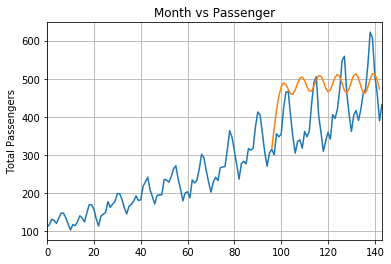

C:\anaconda\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
train(epochs, seq_len, input_size, train_dataloader)

In [42]:
# #обучение
# epochs = 150
# seq_len = look_back
# input_size = 1
# for i in range(epochs):
#     for seq, labels in train_dataloader:
#         optimizer.zero_grad()
#         seq = seq.view(seq_len, batch_size, input_size)
#         model.hidden_cell = (torch.zeros(model.num_layers, batch_size, model.hidden_size),
#                             torch.zeros(model.num_layers, batch_size, model.hidden_size))
#         y_pred = model(seq)
#         single_loss = loss_function(y_pred, labels)
#         single_loss.backward()
#         optimizer.step()
    
    
#     #предсказание
#     pred_len = 5
#     koll_test = len(test)
#     test_inputs = train_dataset[-1, 0][0]
#     test_inputs = test_inputs.tolist()
#     model.eval()
#     for j in range(koll_test):
#         seq = torch.FloatTensor(test_inputs[-pred_len:])
#         with torch.no_grad():
#             model.hidden = (torch.zeros(model.num_layers, batch_size, model.hidden_size),
#                             torch.zeros(model.num_layers, batch_size, model.hidden_size))
#             test_inputs.append(model(seq).item())
    
#     actual_predictions = scaler.inverse_transform(np.array(test_inputs[pred_len:] ).reshape(-1, 1))
#     x = np.arange(143-48, 143, 1)
    
#     clear_output(True)
    
#     plt.title('Month vs Passenger')
#     plt.ylabel('Total Passengers')
#     plt.grid(True)
#     plt.autoscale(axis='x', tight=True)
#     plt.plot(dataset)
#     plt.plot(x,actual_predictions)
#     plt.show()
    
#     if i%25 == 1:
#         print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    

# print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')